# Generative Modeling by Estimating Gradients of Data Distribution in JAX

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/jax/blob/master/docs/notebooks/score_matching.ipynb)

In this notebook we'll implement __Generative Modeling by Estimating Gradients of the Data Distribution__ [[arxiv]](https://arxiv.org/abs/1907.05600).

The paper builds on a technique called __Score Matching__ to iteratively refine images into samples from the real data. This technique takes advantage of some recent theorems to learn the gradients of data probability distribution. Implementing this in your typical DL framework would become an issue. However, [__`JAX`__](https://github.com/google/jax) ain't your typical DL framework. JAX makes implementing complex math no harder than writing it on a piece of paper.

Let's begin with a simple task: learn to sample from a peculiar probability distribution. Like a swiss roll, for example:

![img](https://i.imgur.com/zMR6Iej.jpg)

well... minus the chocolate. Sorry for that.

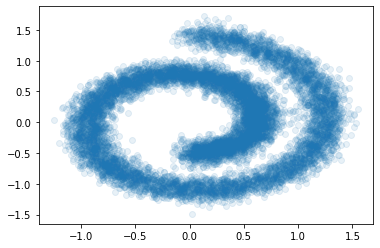

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from sklearn.datasets import make_swiss_roll

def sample_batch(size, noise=1.0):
    x, _= make_swiss_roll(size, noise=noise)
    x = x[:, [0, 2]] / 10.0
    return np.array(x)

plt.scatter(*sample_batch(10**4).T, alpha=0.1)

## Compute score matching objective

The method we apply here was originally proposed by [Hyvarinen et al. (2005)](http://jmlr.org/papers/volume6/hyvarinen05a/old.pdf). The idea behind score matching is to __learn scores:__ the gradients of $\log p(x)$ w.r.t. $x$. When trained this model can "improve" a sample $x$ by changing it in the direction of highest log-probability. However, training such model can get tricky. When predicting a continuous variable, ML folks usually minimize squared error:

$$ L_{mse} = E_{x \sim p(x)} \left\lVert model(x) - \nabla_x \log p(x) \right\lVert_2^2 $$

One can't minimize this explicitly because the real $\nabla_x \log p(x)$ is usually unknown. However under broad assumptions on $p(x)$ and a sufficiently powerful model, one can say that ` ... math happens ... ` and therefore the arg-minimum of $L_{mse}$ can be found by minimizing a more tractable objective:

$$ L_{matching} = E_{x \sim p(x)} \space tr( \space \mathbf{J}_x [\space model(x)  \space]) + \frac12 \left\Vert model(x) \right\lVert_2^2 $$

Here $tr( \space \mathbf{J}_x [\space model(x)  \space])$ is a trace of Jacobian of $model(x)$ w.r.t. $x$. Now all it takes is to minimize the second objective with backpropagation... that is, if you can compute Jacobians. Thankfully, we have __jax__!

In [2]:
import jax
import jax.numpy as jnp
from jax.experimental import optimizers
from jax.experimental import stax
from functools import partial

# Set up network to predict scores
net_init, net_apply = stax.serial(
    stax.Dense(128), stax.Softplus,
    stax.Dense(128), stax.Softplus,
    stax.Dense(2),
)

# Create optimizer. Note that both network and optimizer returns pure (stateless) functions
opt_init, opt_update, get_params = optimizers.adam(1e-3)

In [3]:
# v-- jax.jit compiles a function for efficient CPU and GPU execution

@jax.jit
def compute_loss(net_params, inputs):
    # v-- a function that computes jacobian by forward mode differentiation
    jacobian = jax.jacfwd(net_apply, argnums=-1)
    
    # we use jax.vmap to vectorize jacobian function along batch dimension
    batch_jacobian = jax.vmap(partial(jacobian, net_params))(inputs)  # [batch, dim, dim]
    
    trace_jacobian = jnp.trace(batch_jacobian, axis1=1, axis2=2)
    output_norm_sq = jnp.square(net_apply(net_params, inputs)).sum(axis=1)
    
    return jnp.mean(trace_jacobian + 1/2 * output_norm_sq)


@jax.jit
def train_step(step_i, opt_state, batch):
    net_params = get_params(opt_state)
    loss = compute_loss(net_params, batch)
    grads = jax.grad(compute_loss, argnums=0)(net_params, batch)
    return loss, opt_update(step_i, grads, opt_state)

__Note__: we use `jax.jacfwd` since the input dimension is only 2

## Training loop

In [4]:
from IPython.display import clear_output

out_shape, net_params = net_init(jax.random.PRNGKey(seed=42), input_shape=(-1, 2))
opt_state = opt_init(net_params)

loss_history = []

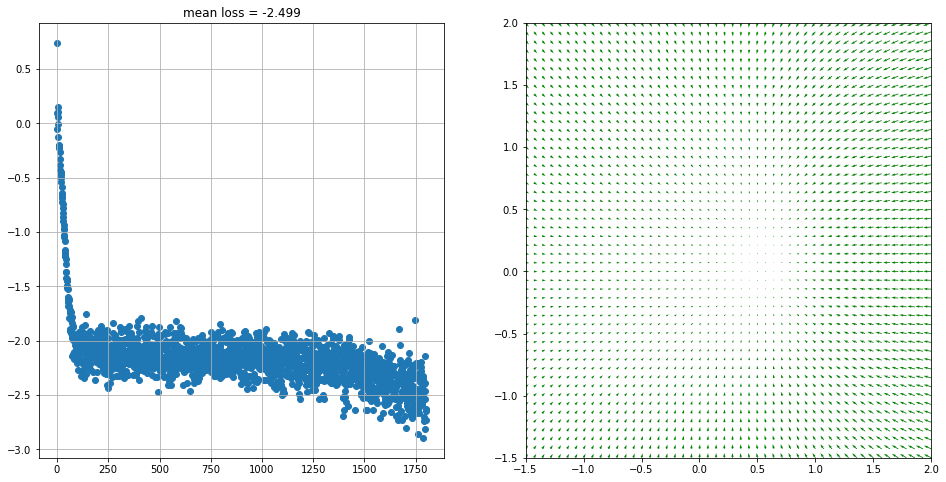

In [5]:
for i in range(2000):
    x = sample_batch(size=128)
    loss, opt_state = train_step(i, opt_state, x)
    loss_history.append(loss.item())
    
    if i % 200 == 0:
        clear_output(True)
        plt.figure(figsize=[16, 8])
        plt.subplot(1, 2, 1)
        plt.title("mean loss = %.3f" % jnp.mean(jnp.array(loss_history[-32:])))
        plt.scatter(jnp.arange(len(loss_history)), loss_history)
        plt.grid()
        
        plt.subplot(1, 2, 2)
        net_params = get_params(opt_state)
        xx = jnp.stack(jnp.meshgrid(jnp.linspace(-1.5, 2.0, 50), jnp.linspace(-1.5, 2.0, 50)), axis=-1).reshape(-1, 2)
        scores = net_apply(net_params, xx)
        scores_norm = jnp.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
        scores_log1p = scores / (scores_norm + 1e-9) * jnp.log1p(scores_norm)

        plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='green')
        plt.xlim(-1.5, 2.0)
        plt.ylim(-1.5, 2.0)
        plt.show()

## Plot gradient directions
Once the model is trained we can use it to predict scores at each point. Since those are gradient vectors, we'll use [`Quiver Plot`](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.quiver.html) to draw them.

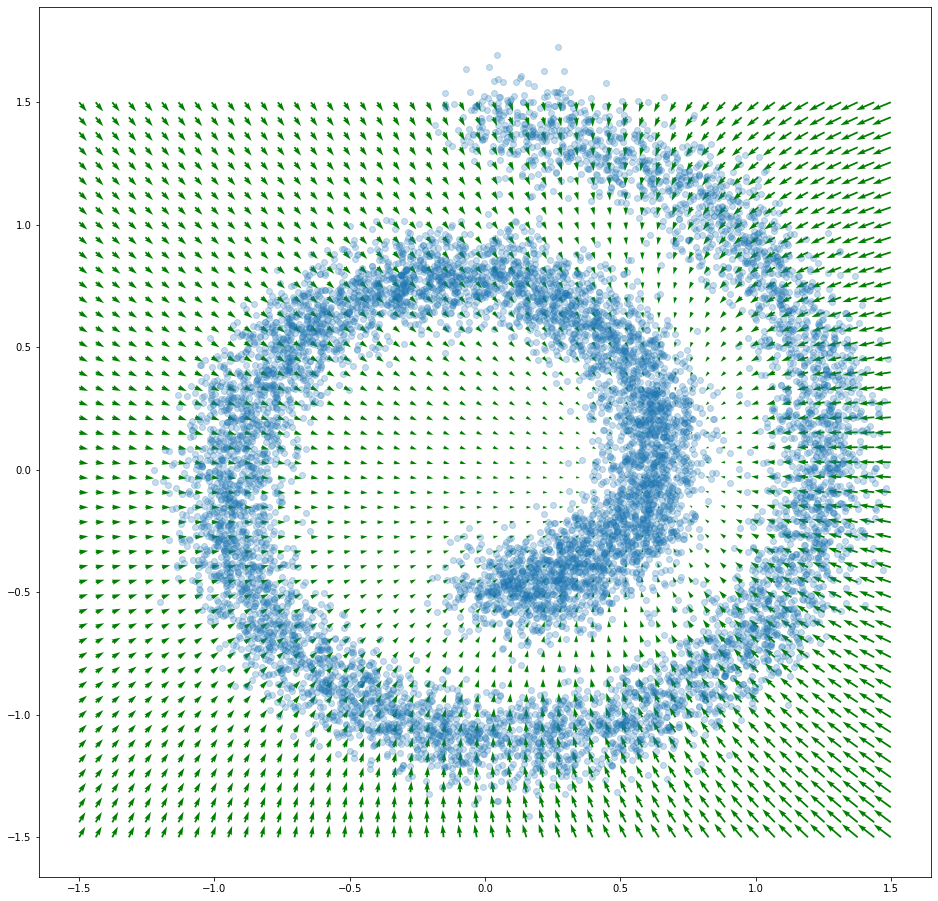

In [6]:
plt.figure(figsize=[16, 16])

net_params = get_params(opt_state)
xx = jnp.stack(jnp.meshgrid(jnp.linspace(-1.5, 1.5, 50), jnp.linspace(-1.5, 1.5, 50)), axis=-1).reshape(-1, 2)
scores = net_apply(net_params, xx)
scores_norm = jnp.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
scores_log1p = scores / (scores_norm + 1e-9) * jnp.log1p(scores_norm)

plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='green')
plt.scatter(*sample_batch(10_000).T, alpha=0.25)

A hot new paper by [Song et al. (2019)](https://arxiv.org/abs/1907.05600) uses this method to generate images by iterative refinement... Apparently it took DL researchers 14 years to understand the proof :)

Seriously though, this paper takes advantage of two new ideas: sampling with __Langevin Dynamics__ and scaling to high dimensions with __Sliced Score Matching__. We'll cover them one at a time.

## Sampling with Langevin Dynamics

Once we have $\nabla_x \log p(x)$, we can use it to generate data. One simple thing you can do is a gradient ascent w.r.t image to find a local maximum of $p(x)$:

$$\hat x_{t + 1} := x_t + \epsilon \nabla_{x_t} \log p(x_t)$$

In order to sample $x \sim p(x)$, one can run a slightly more sophisticated procedure:

$$\hat x_{t+1} := \hat x_t + \frac \epsilon 2 \nabla_{\hat x_t} \log p(\hat x_t) + \sqrt \epsilon z_t, \quad z_t \sim N(0, I)$$


Performing this update multiple times in an MCMC fashion is a special case of Langevin Dynamics. Under $\epsilon \rightarrow 0, t \rightarrow \inf$: $\hat x_t$ converges to a sample from $p(x)$. You can find a more detailed explanation and a formal proof in [Welling et al. (2011)](https://www.ics.uci.edu/~welling/publications/papers/stoclangevin_v6.pdf) and further exploration of SGLD in [The et al. (2014)](https://arxiv.org/abs/1409.0578) and [Vollmer et al. (2015)](https://arxiv.org/abs/1501.00438).

In practice, we can initialize $x_0$ from some initial guess (e.g. uniform distribution over data space) and $\epsilon$ to some positive value. As the sampling progresses, we can anneal $\epsilon$ it until we are satisfied with the samples. Okay, now let's go implement that :)

In [7]:
def sample_langevin(x_initial, *, net_params, key, eps=1e-2, eps_decay=0.9, num_steps=15, temperature=1.0):
    """ sample x ~ p(x) by applying approximate Langvenin Dynamics, return a sequence of x_t """
    x_t, x_sequence = x_initial, [x_initial]
    
    for t in range(num_steps):
        key, subkey = jax.random.split(key)
        z_t = jax.random.normal(subkey, shape=x_t.shape)
        x_t = x_t + eps / 2 * net_apply(net_params, x_t) + jnp.sqrt(eps) * temperature * z_t
        x_sequence.append(x_t)
        eps *= eps_decay
        
    return jnp.stack(x_sequence)

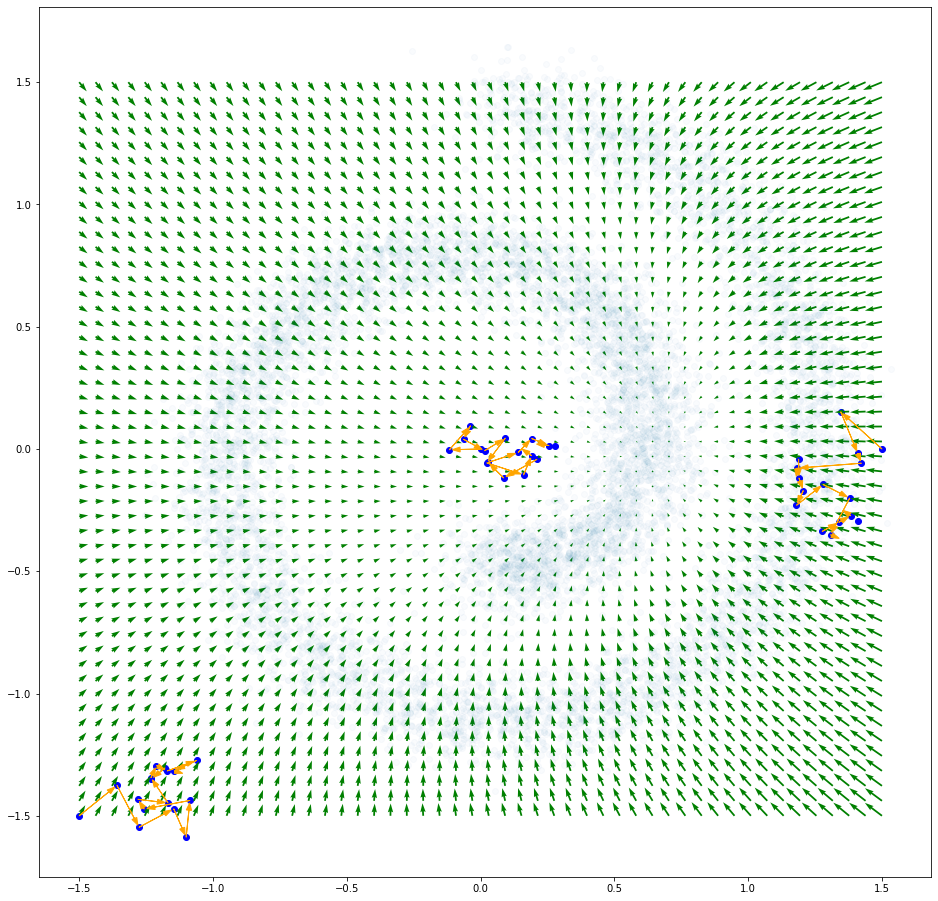

In [8]:
plt.figure(figsize=[16, 16])

key = jax.random.PRNGKey(42)
net_params = get_params(opt_state)

for x_initial in jnp.array([[-1.5, -1.5], [0, 0], [1.5, 0]]):
    key, subkey = jax.random.split(key)
    # sample x sequence
    xx = sample_langevin(x_initial, key=subkey, net_params=net_params)
    plt.scatter(xx.T[0], xx.T[1], color="blue")

    # draw arrows for each mcmc step
    deltas = (xx[1:] - xx[:-1])
    deltas = deltas - deltas / jnp.linalg.norm(deltas, keepdims=True, axis=-1) * 0.04
    for i, arrow in enumerate(deltas):
        plt.arrow(xx[i][0], xx[i][1], arrow[0], arrow[1], width=1e-4, head_width=2e-2, color="orange")
    
# plot data points and gradients
plt.plot()
xx = jnp.stack(jnp.meshgrid(jnp.linspace(-1.5, 1.5, 50), jnp.linspace(-1.5, 1.5, 50)), axis=-1).reshape(-1, 2)
scores = net_apply(net_params, xx)
scores_norm = jnp.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
scores_log1p = scores / (scores_norm + 1e-9) * jnp.log1p(scores_norm)
plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='green')
plt.scatter(*sample_batch(10_000).T, alpha=0.025)

## Sliced Score Matching

Now the problem with our previous loss function is that the computation of $tr(\mathbf{J}_x [\space model(x)])$ takes a $O(N^2 + N)$ time to compute, thus not being suitable for high-dimensional problems. The solution is using Jacobian vector products which can be easily computed using forward mode auto-differentiation. This method is called Sliced Score Matching and was proposed by [Yang Song et al. (2019)](https://arxiv.org/abs/1905.07088).

Our new objective looks like this:

$$E_{\mathbf{v} \sim \mathcal{N}(0, 1)} E_{x \sim p(x)} [ \mathbf{v}^T \mathbf{J}_x[model(x)] \mathbf{v} + \frac{1}{2} (\mathbf{v}^T model(x))^2 ]$$

Jacobian vector products, by the way, can be easily computed using `jax.jvp`.

In [9]:
@jax.jit
def compute_ssm_loss(net_params, inputs, key):
    apply = jax.jit(partial(net_apply, net_params))
    batch_dot = partial(jnp.einsum, 'bu,bu->b')
    
    # generate random vectors from N(0, I)
    v = jax.random.normal(key, shape=inputs.shape)

    # predict score and compute jacobian of score times v
    score, jac_v = jax.jvp(apply, [inputs], [v])
    
    return jnp.mean(batch_dot(v, jac_v) + 1/2 * batch_dot(v, score) ** 2)

@jax.jit
def train_step(step_i, opt_state, batch, key):
    # the new compute_loss is random key dependent, thus we need a new train_step function
    net_params = get_params(opt_state)
    loss = compute_ssm_loss(net_params, batch, key)
    grads = jax.grad(compute_ssm_loss, argnums=0)(net_params, batch, key)
    return loss, opt_update(step_i, grads, opt_state)

__Note:__ we compute Jacobian with `jax.jacfwd` (forward-mode differentiation) because the input dimension of the network is just 2. You can read more about autograd modes in jax [documentation](https://jax.readthedocs.io/en/latest/jax.html?highlight=jacfwd#jax.jacfwd) and on wikipedia [wiki](https://en.wikipedia.org/wiki/Automatic_differentiation)

In [10]:
key = jax.random.PRNGKey(42)
key, subkey = jax.random.split(key)
out_shape, net_params = net_init(subkey, input_shape=(-1, 2))
opt_state = opt_init(net_params)

loss_history = []

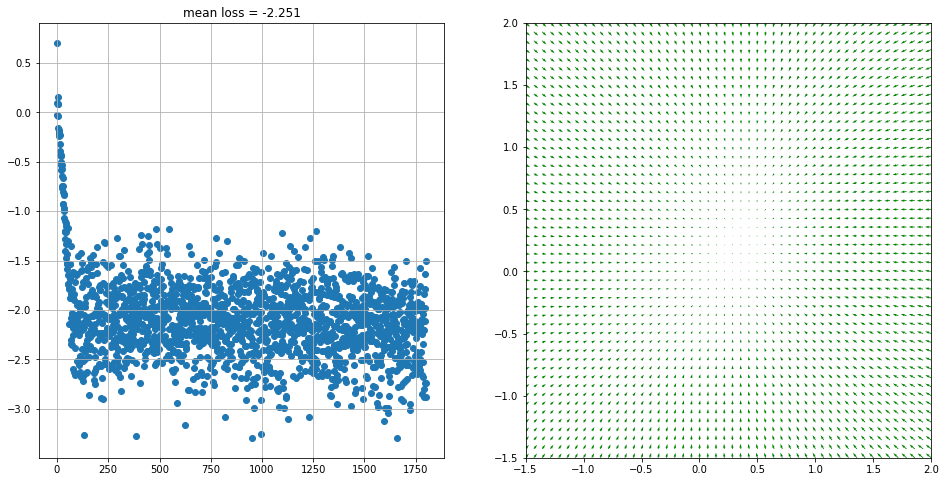

In [11]:
for i in range(2_000):
    x = sample_batch(size=128)
    
    key, subkey = jax.random.split(key)
    loss, opt_state = train_step(i, opt_state, x, subkey)
    loss_history.append(loss.item())
    
    if i % 200 == 0:
        clear_output(True)
        plt.figure(figsize=[16, 8])
        plt.subplot(1, 2, 1)
        plt.title("mean loss = %.3f" % jnp.mean(jnp.array(loss_history[-32:])))
        plt.scatter(jnp.arange(len(loss_history)), loss_history)
        plt.grid()
        
        plt.subplot(1, 2, 2)
        net_params = get_params(opt_state)
        xx = jnp.stack(jnp.meshgrid(jnp.linspace(-1.5, 2.0, 50), jnp.linspace(-1.5, 2.0, 50)), axis=-1).reshape(-1, 2)
        scores = net_apply(net_params, xx)
        scores_norm = jnp.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
        scores_log1p = scores / (scores_norm + 1e-9) * jnp.log1p(scores_norm)

        plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='green')
        plt.xlim(-1.5, 2.0)
        plt.ylim(-1.5, 2.0)
        plt.show()

## Easy? Let's go deeper!
MNIST 8x8, computing a full Jacobian would require 64 passes through the network

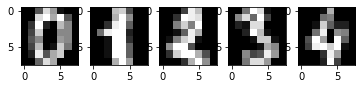

In [12]:
from sklearn.datasets import load_digits
import numpy as np

X, _ = load_digits(return_X_y=True)

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X[i].reshape(8, 8), cmap='gray')
    

def sample_batch(size, noise=0.1):
    ix = np.random.randint(0, len(X), size=size)
    return jnp.array(X[ix] / 16 + noise * np.random.randn(size, 64))

In [13]:
# Set up network to predict scores
net_init, net_apply = stax.serial(
    stax.Dense(128), stax.Softplus,
    stax.Dense(128), stax.Softplus,
    stax.Dense(64),
)

# Create optimizer. Note that both network and optimizer returns pure (stateless) functions
opt_init, opt_update, get_params = optimizers.adam(1e-3)

key = jax.random.PRNGKey(seed=42)
key, subkey = jax.random.split(key)
out_shape, net_params = net_init(subkey, input_shape=(-1, 64))
opt_state = opt_init(net_params)

loss_history = []

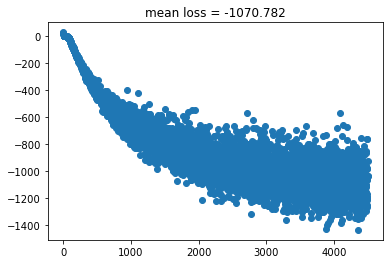

In [14]:
for i in range(5_000):
    x = sample_batch(size=128)
    key, subkey = jax.random.split(key)
    loss, opt_state = train_step(i, opt_state, x, subkey)
    loss_history.append(loss.item())
    
    if i % 500 == 0:
        clear_output(True)
        plt.title("mean loss = %.3f" % jnp.mean(jnp.array(loss_history[-32:])))
        plt.scatter(jnp.arange(len(loss_history)), loss_history)
        plt.show()

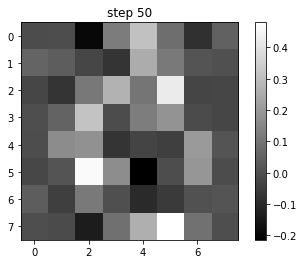

In [15]:
key, subkey = jax.random.split(key)
x = 0.1 * jax.random.uniform(subkey, shape=(64,))

xx = sample_langevin(x, net_params=get_params(opt_state), key=key,
                     eps=0.05, eps_decay=0.98, num_steps=50,
                     temperature=0.02)  # set low temperature to compensate for noise in training data

for t, x_t in enumerate(xx):
    clear_output(True)
    plt.imshow(x_t.reshape(8, 8), cmap='gray')
    plt.title('step %i' % t); plt.colorbar(); plt.show()

## This is just the beginning

In their paper, [Song et al. (2019)](https://arxiv.org/abs/1907.05600) propose a more sophisticated sampling procedure that can efficiently sample larger images. They also utilize a technique called _Denoising Score Matching_ which can be safely ported even to earthling frameworks like tensorflow and pytorch. Go take a look!

![celeba](https://media.giphy.com/media/jp3MBYHawJi62YoTNI/giphy.gif)

Notebook author: [Denis Mazur](https://github.com/deniskamazur), edited by [Just Heuristic](https://github.com/justheuristic)